In the second part of this assignment, we will implement Q-learning.

### **Preparation**
The following code is the preparation for importing packages.

In [ ]:
!pip install numpy
!pip install imageio
!pip install pygame
!pip install tqdm

In [ ]:
import numpy as np
from tqdm import tqdm

# To visualize
import pygame
import imageio
from PIL import Image
import IPython
import os

os.environ["SDL_VIDEODRIVER"] = "dummy"

pygame 2.5.2 (SDL 2.28.2, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


Before start, we need to upload some assets for visualization.

Assets (just for reference; you don't need to download the assets individually):
- Elf and stool from https://franuka.itch.io/rpg-snow-tileset
- Rock from https://toppng.com/show_download/226268/rock-rock-pixel-art/large
- All other assets by Mel Tillery http://www.cyaneus.com/


In [ ]:
# Upload img.zip
from google.colab import files

uploaded = files.upload()

Saving img.zip to img.zip


In [ ]:
!unzip img.zip

unzip:  cannot find or open img.zip, img.zip.zip or img.zip.ZIP.


### **Q-Learning Implementation**

In this assignment, you should use only NumPy to build the Q-learning model.

**DO NOT** use other libraries which directly implement Q-learning.

**DO NOT** modify other parts of the skeleton code.

Follow the comments. They'll give you instructions on what to code.

### **Step 1. Environment Settings**
Here, we give the details of our experimental settings.

#### **Helper function**
We provide a helper function to visualize the environment.

In [ ]:
# Set parameters for visualization
window_size = (512, 512)

# Load images
hole_image = pygame.image.load("cracked_hole.png")
rock_image = pygame.image.load("rock.png")
ice_image = pygame.image.load("ice.png")
goal_image = pygame.image.load("goal.png")
start_image = pygame.image.load("stool.png")
elfs = [
    "elf_left.png",
    "elf_down.png",
    "elf_right.png",
    "elf_up.png",
]
elf_images = [pygame.image.load(f_name) for f_name in elfs]

# Set display
pygame.init()
pygame.display.init()
pygame.display.set_caption("SlipperyFrozenLake")

window_surface = pygame.Surface(window_size)
cell_width = 64
cell_height = 64
smaller_cell_scale = 1
small_cell_width = int(cell_width * smaller_cell_scale)
small_cell_height = int(cell_height * smaller_cell_scale)

def _center_small_rect(big_rect, small_dims):
    offset_w = (big_rect[2] - small_dims[0]) / 2
    offset_h = (big_rect[3] - small_dims[1]) / 2
    return (
        big_rect[0] + offset_w,
        big_rect[1] + offset_h,
    )

def render(lake, row, col, a_prev):
    # Prepare images
    #elf_img = elf_images[a_prev]
    elf_img = pygame.transform.scale(elf_images[a_prev], (cell_width, cell_height))
    hole_img = pygame.transform.scale(hole_image, (cell_width, cell_height))
    rock_img = pygame.transform.scale(rock_image, (cell_width, cell_height))
    ice_img = pygame.transform.scale(ice_image, (cell_width, cell_height))
    goal_img = pygame.transform.scale(goal_image, (cell_width, cell_height))
    start_img = pygame.transform.scale(start_image, (small_cell_width, small_cell_height))

    for y in range(8):
        for x in range(8):
            rect = (x * cell_width, y * cell_height, cell_width, cell_height)
            if lake[y][x] == "H":
                window_surface.blit(hole_img, (rect[0], rect[1]))
            elif lake[y][x] == "R":
                window_surface.blit(rock_img, (rect[0], rect[1]))
            elif lake[y][x] == "G":
                window_surface.blit(ice_img, (rect[0], rect[1]))
                goal_rect = _center_small_rect(rect, goal_img.get_size())
                window_surface.blit(goal_img, goal_rect)
            elif lake[y][x] == "S":
                window_surface.blit(ice_img, (rect[0], rect[1]))
                stool_rect = _center_small_rect(rect, start_img.get_size())
                window_surface.blit(start_img, stool_rect)
            else:
                window_surface.blit(ice_img, (rect[0], rect[1]))

            pygame.draw.rect(window_surface, (180, 200, 230), rect, 1)

    cell_rect = (
        col * cell_width,
        row * cell_height,
        cell_width,
        cell_height,
    )

    elf_rect = _center_small_rect(cell_rect, elf_img.get_size())
    window_surface.blit(elf_img, elf_rect)
    return np.transpose(np.array(pygame.surfarray.pixels3d(window_surface)), axes=(1, 0, 2))

#### **Environment**
We will implement a Q-learning framework to train the agent on **SlipperyFrozenLake**, which is modified from the **FrozenLake** provided in `gym` library. The rules are provided as follows:

- The agent starts in the starting point (S), and the goal is to reach the goal (G) while avoiding the holes (H).
- The agent can choose four actions: Left (0), Down (1), Right (2), Up (3)
- If the agent choose one action, the agent moves toward the selected direction until one of the condition is satisfied.
1. The agent stops if the rock (R) blocks the agent.
2. The agent stops if the agent reaches the boundary of the lake.
3. The agent stops if the agent meets the hole (H). This is the case that we should avoid.
4. The agent stops if the agent reaches the goal (G). This is the case that we want.

We use the following map:

In [ ]:
### DO NOT MODIFY ###
lake = [
    "S-----R-",
    "-H-R---R",
    "R----R--",
    "-HR-RH--",
    "R----R-R",
    "-R------",
    "-H------",
    "-R-HG-R-"
]

The set of actions are given as follows:

In [ ]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

Using the helper function above (`render`), we can visualize the environment as follows:

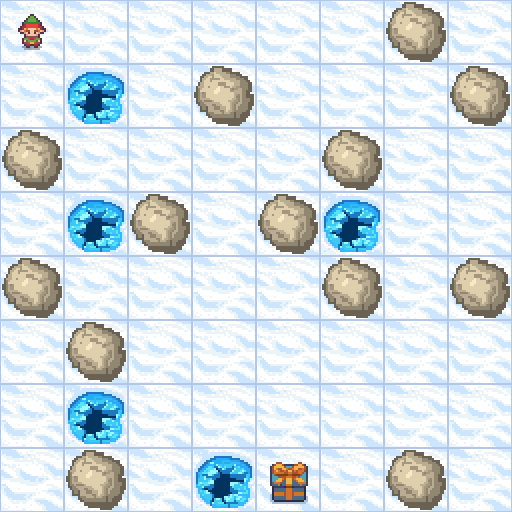

In [ ]:
rgb_array = render(lake, 0, 0, DOWN)
img = Image.fromarray(rgb_array)
img

We implement `next_step`, which calculates (next state, reward, terminate) tuple for a given (state, action) pair.

The reward is given only if the agent reaches the goal (+10).

In [ ]:
def next_step(row, col, action):
    reward = 0 # Calculated reward
    terminate = False # Boolean value indicating whether the episode is terminated or not

    while True:
        # 1-1. Implement the case when the agent meets a hole (which terminates the episode).
        # At the end, the agent must stand on the hole.
        ############################### IMPLEMENT HERE ###############################
        if lake[row][col] == "H":
            terminate = True
            break
        ##############################################################################

        # 1-2. Implement the case when the agent meets the goal (which terminates the episode with positive reward of 10).
        # At the end, the agent must stand on the goal.
        ############################### IMPLEMENT HERE ###############################
        if lake[row][col] == "G":
            terminate = True
            reward = 10.0
            break
        ##############################################################################

        # 1-3. Implement the case when the agent faces a rock.
        # Note that the agent cannot reach to the cell containing rock.
        ############################### IMPLEMENT HERE ###############################
        # rock 만나면 다시 원위치 복구
        if lake[row][col] == "R":
          if action == LEFT:
            col+=1
          elif action == RIGHT:
            col -= 1
          elif action == UP:
            row+=1
          elif action == DOWN:
            row -=1
          break
        ##############################################################################

        # 1-4. Implement the case when the agent reaches the boundary of the lake.
        # Note that the agent cannot move out of the boundary.
        ############################### IMPLEMENT HERE ###############################
        if action == LEFT and col ==0:
          break
        elif action ==RIGHT and col ==7:
          break
        elif action == UP and row ==0:
          break
        elif action ==DOWN and row==7:
          break
        ##############################################################################

        # 1-5. If no condition is satisfied, prepare next iteration (change the position of the agent)
        ############################### IMPLEMENT HERE ###############################
        if action == LEFT:
          col -=1
        elif action ==RIGHT:
          col+=1
        elif action ==UP:
          row-=1
        elif action ==DOWN:
          row+=1
        ##############################################################################

    return (row, col), reward, terminate

We give some testcases to check the implementation of `next_step`.

In [ ]:
assert next_step(0, 0, RIGHT) == ((0, 5), 0, False)
assert next_step(0, 0, UP) == ((0, 0), 0, False)
assert next_step(3, 7, LEFT) == ((3, 5), 0, True)
assert next_step(6, 4, DOWN) == ((7, 4), 10, True)
print("Sanity check done!")

Sanity check done!


### **Step 2. Initialize Q-Table**
To perform Q-learning, we first need to initialize the Q-table. Q-table contains the state-action values for each (state, action) pair.

In [ ]:
# 2. Initialize Q-table.
# Q-table contains the state-action values for each (state, action) pair
############################### IMPLEMENT HERE ###############################
# map 크기가 64개 -> state 개수 64개
q_table = np.zeros((64,4))
##############################################################################

### **Step 3. Implement Epsilon Greedy Strategy**
Epsilon greedy strategy is a policy that handles the exploration/exploitation trade-off. For a given epsilon, the agent chooses an action based on the following strategy:
- With probability epsilon, we randomly select the possible actions.
- With probability 1 - epsilon, we greedily choose the next action based on the Q-table.

In [ ]:
# to_s converts each (row, col) pair into an integer (row * 8 + col), which is the index representing the state (row, col)
def to_s(row, col):
    return row * 8 + col

In [ ]:
def epsilon_greedy(row, col, q_table, epsilon):
    if np.random.rand() < epsilon:
        # 3-1. Implement exploration.
        ############################### IMPLEMENT HERE ###############################
        a = np.random.randint(4)  #아무 action이나 선택
        ##############################################################################
    else:
        # 3-2. Implement exploitation.
        # Note that if there are multiple candidates (due to same values), then the agent must randomly choose the action among them.
        ############################### IMPLEMENT HERE ###############################
        s = to_s(row, col)  #64개 state중에 어떤 state인지 계산
        a_candidates=np.where(q_table[s]==q_table[s].max())[0] #q_table에서 최대인 action 중 첫번째 action 선택
        a=np.random.choice(a_candidates)
        ##############################################################################
    return a

### **Step 4. Train the agent**
In this step, we are going to train the agent.

Before training, we first watch the behavior of the (untrained) agent.

In [ ]:
# Generates gif file of the agent's movement based on the input q_table
def movement_gif(file, q_table):
    row = 0
    col = 0
    done = False
    images = []

    rgb_array = render(lake, 0, 0, DOWN)
    img = Image.fromarray(rgb_array)
    for _ in range(4):
        images.append(img)

    while not done:
        a = epsilon_greedy(row, col, q_table, 0)

        s = to_s(row, col)
        (row, col), r, done = next_step(row, col, a)

        rgb_array = render(lake, row, col, a)
        img = Image.fromarray(rgb_array)
        images.append(img)

    for _ in range(7):
        images.append(img)

    imageio.mimsave(file, [np.array(img) for i, img in enumerate(images)], fps=2)

In [ ]:
### DO NOT CHANGE THE SEED ###
np.random.seed(123)
movement_gif("lake_untrained.gif", q_table)

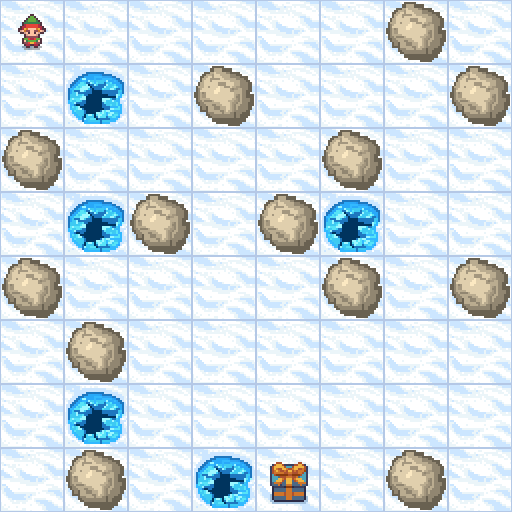

In [ ]:
IPython.display.Image(filename="lake_untrained.gif")

As we can see, the agent fails to reach the goal. We will train the agent so that the agent can safely reach the goal.

First, we set some parameters (learning rate and discount rate).

In [ ]:
learning_rate = 0.1
discount_rate = 0.8

Then we implement the overall training.

In [ ]:
def train_episode(epsilon):
    row = 0
    col = 0
    done = False

    while not done:
        # 4-1. Choose the action using epsilon greedy algorithm
        ############################### IMPLEMENT HERE ###############################
        a = epsilon_greedy(row, col, q_table, epsilon)
        ##############################################################################

        # 4-2. Calculate the next state and the reward
        ############################### IMPLEMENT HERE ###############################
        (row_new, col_new), r, done = next_step(row, col, a)
        ##############################################################################

        # 4-3. Update Q-table
        ############################### IMPLEMENT HERE ###############################
        s = to_s(row, col)
        s_next = to_s(row_new, col_new)
        value = q_table[s,a]
        value_next = r+discount_rate*np.max(q_table[s_next])
        q_table[s,a] = (1-learning_rate)*value+learning_rate*value_next #optimization 식 - q값 update
        ##############################################################################

        # 4-4. Update current state
        ############################### IMPLEMENT HERE ###############################
        row = row_new
        col = col_new
        ##############################################################################

def train(num_epoch=10000):
    # 4-5. Train the agent.
    # We use epsilon = 1 / (i + 1) in i-th episode. (Note that i=0 in the first episode)
    for i in tqdm(range(num_epoch)):
        ############################### IMPLEMENT HERE ###############################
        train_episode(1/(i+1))
        ##############################################################################

Using the implemented functions, we train the agent.

In [ ]:
train()

100%|██████████| 10000/10000 [00:05<00:00, 1852.53it/s]


Here, we show the trained Q-table.

In [ ]:
q_table

array([[8.58993459e-02, 1.92413213e-02, 1.07374182e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [4.78035596e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.68185595e-07, 1.34217728e+00, 0.00000000e+00, 2.13698080e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.32786484e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 2.55013683e-01, 1.67772160e

### **Step 5. Test the agent**
In this step, we will test the trained agent.

First, we calculate the average reward for 10000 episode.

In [ ]:
def test_episode():
    row = 0
    col = 0
    reward_total = 0
    done = False

    while not done:
        # 5-1. Choose the action using greedy algorithm (Note: This step is different from epsilon greedy!)
        ############################### IMPLEMENT HERE ###############################
        a = epsilon_greedy(row,col, q_table, 0)
        ##############################################################################

        # 5-2. Calculate the next state and the reward
        ############################### IMPLEMENT HERE ###############################
        (row_new, col_new), r, done = next_step(row, col ,a)
        ##############################################################################

        # 5-3. Update current state and total reward
        ############################### IMPLEMENT HERE ###############################
        row = row_new
        col = col_new
        reward_total += r
        ##############################################################################

    return reward_total

def test(num_epoch=10000):
    list_reward = []
    # 5-4. Test the agent for num_epoch episodes.
    # We should save the resulting reward in list_reward.

    for i in tqdm(range(num_epoch)):
        ############################### IMPLEMENT HERE ###############################
        reward = test_episode()
        list_reward.append(reward)
        ##############################################################################

    # 5-5. Calculate the average reward.
    ############################### IMPLEMENT HERE ###############################
    reward_average = np.mean(list_reward)
    ##############################################################################

    return reward_average

In [ ]:
test()

100%|██████████| 10000/10000 [00:03<00:00, 2581.89it/s]


10.0

We now visualize the movement of the trained agent.

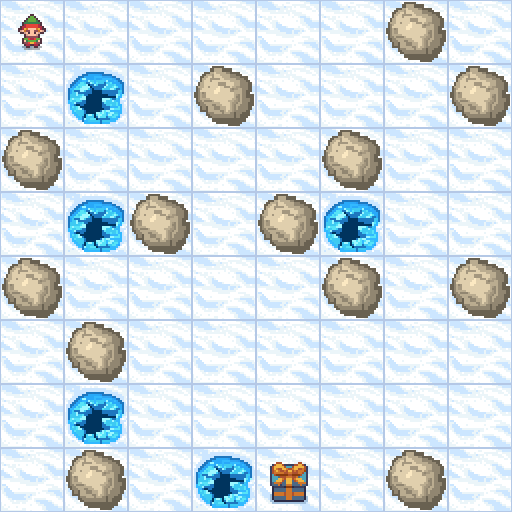

In [ ]:
# 6-1. Make the gif file of the trained agent's movement.
movement_gif("lake_trained.gif", q_table)

# 6-2. Visualize the gif file.
IPython.display.Image(filename="lake_trained.gif")